In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
# muzete pridat libovolnou zakladni knihovnu ci knihovnu predstavenou na prednaskach
# dalsi knihovny pak na dotaz
from sys import getsizeof
from pickle import load
import gzip as gz

In [87]:
import matplotlib
print(matplotlib.__version__)


3.3.2


In [167]:
def get_dataframe(filename: str, verbose: bool = False) -> pd.DataFrame:
    df = None
    with gz.open(filename, 'rb') as f:
        df = load(f)
    if verbose:
        print(f"orig_size={getsizeof(df)/1_048_576:.2f} MB")

    for col in df.columns:
        df[col].replace(r'(^\s*$)|-1', np.NAN, inplace=True, regex=True)
        if col in ["p36", "p37", "weekday(p2a)", "p2b", "p6", "p7", "p8", "p9",  
                   "p10", "p11", "p12", "p13a", "p13b", "p13c", "p14", "p15",
                   "p16", "p17", "p18", "p19", "p20", "p21", "p22", "p23", "p24",
                   "p27", "p28", "p34", "p35", "p39", "p44", "p45a", "p47", 
                   "p48a", "p49", "p50a", "p50b", "p51", "p52", "p53", "p55a", 
                   "p57", "p58", "a", "b", "d", "e", "f", "g", "j", "p5a",
                   ]:
            df[col] = pd.to_numeric(
                df[col], downcast='signed')
        elif col == "p2a":
            df["p2a"] = pd.to_datetime(df["p2a"])
            df["date"] = df["p2a"].copy()
        elif col in ["k", "l", "n", "o", "p", "q", "r", "s", "t", "h", "i"]:
            df[col] = df[col].astype('category')
    if verbose:
        print(f"new_size={getsizeof(df)/1_048_576:.2f} MB")

    return df
df = get_dataframe("accidents.pkl.gz", True)


orig_size=715.66 MB
new_size=153.05 MB


In [47]:
df.dtypes

p1                      object
p36                       int8
p37                    float64
p2a             datetime64[ns]
weekday(p2a)              int8
                     ...      
s                     category
t                     category
p5a                       int8
region                category
date            datetime64[ns]
Length: 66, dtype: object

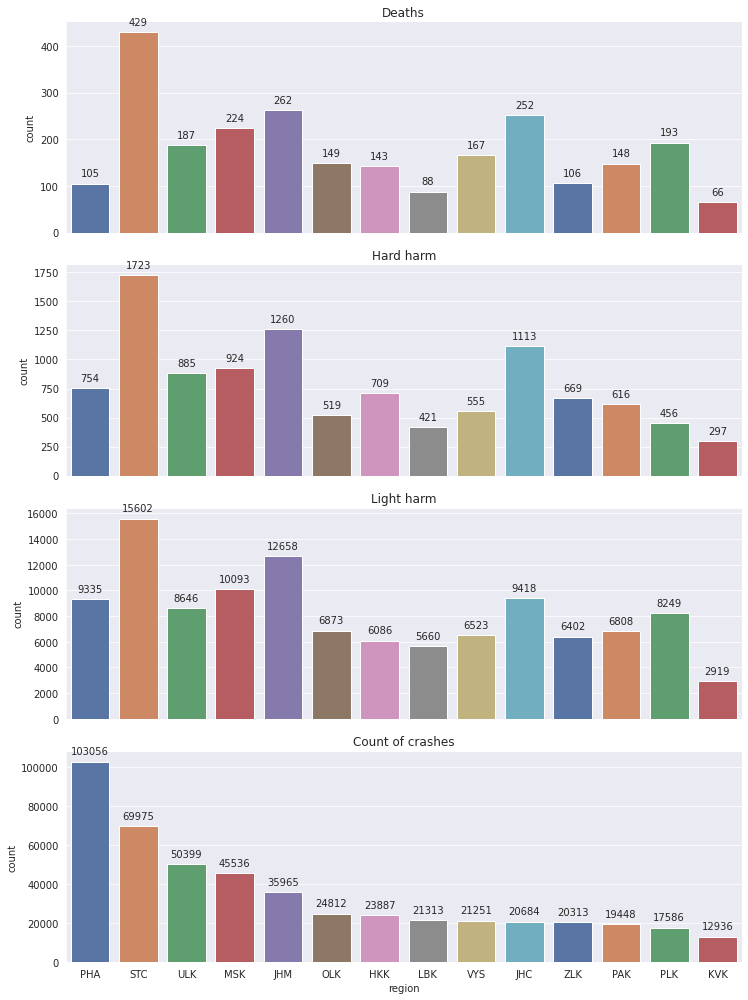

In [119]:
def plot_conseq(df: pd.DataFrame, fig_location: str = None,
                show_figure: bool = False):
    res = df[["region", "p13a", "p13b", "p13c", "p1"]]
    resm = pd.melt(res, id_vars=["region"], value_vars = ("p13a", "p13b", "p13c"), var_name="variable", value_name="count").groupby(["region", "variable"]).agg("sum").reset_index()
    rest = res[["region", "p1"]].groupby(["region"]).agg("count").reset_index().melt(var_name="variable", value_vars=("p1"),value_name="count", id_vars="region")

    res = pd.concat([resm, rest])
    order = res.loc[res["variable"] == "p1"].sort_values(["count"], ascending=False)['region']
    fg = sns.FacetGrid(res,
                      row="variable",
                      sharex=True,
                      sharey=False,
                      height=3.5,
                      aspect=3)
    # set plots on grid
    fg.map(sns.barplot,'region','count', order=order, palette="deep")
    axes = fg.axes.flatten()
    axes[0].set_title("Deaths")
    axes[1].set_title("Hard harm")
    axes[2].set_title("Light harm")
    axes[3].set_title("Count of crashes")
    plt.tight_layout()
    for ax in axes:
        for p in ax.patches:
            ax.annotate(round(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    if fig_location is not None:
        plt.savefig(fig_location)
    if show_figure:
        plt.show()

plot_conseq(df, fig_location="01_nasledky.png", show_figure=True)


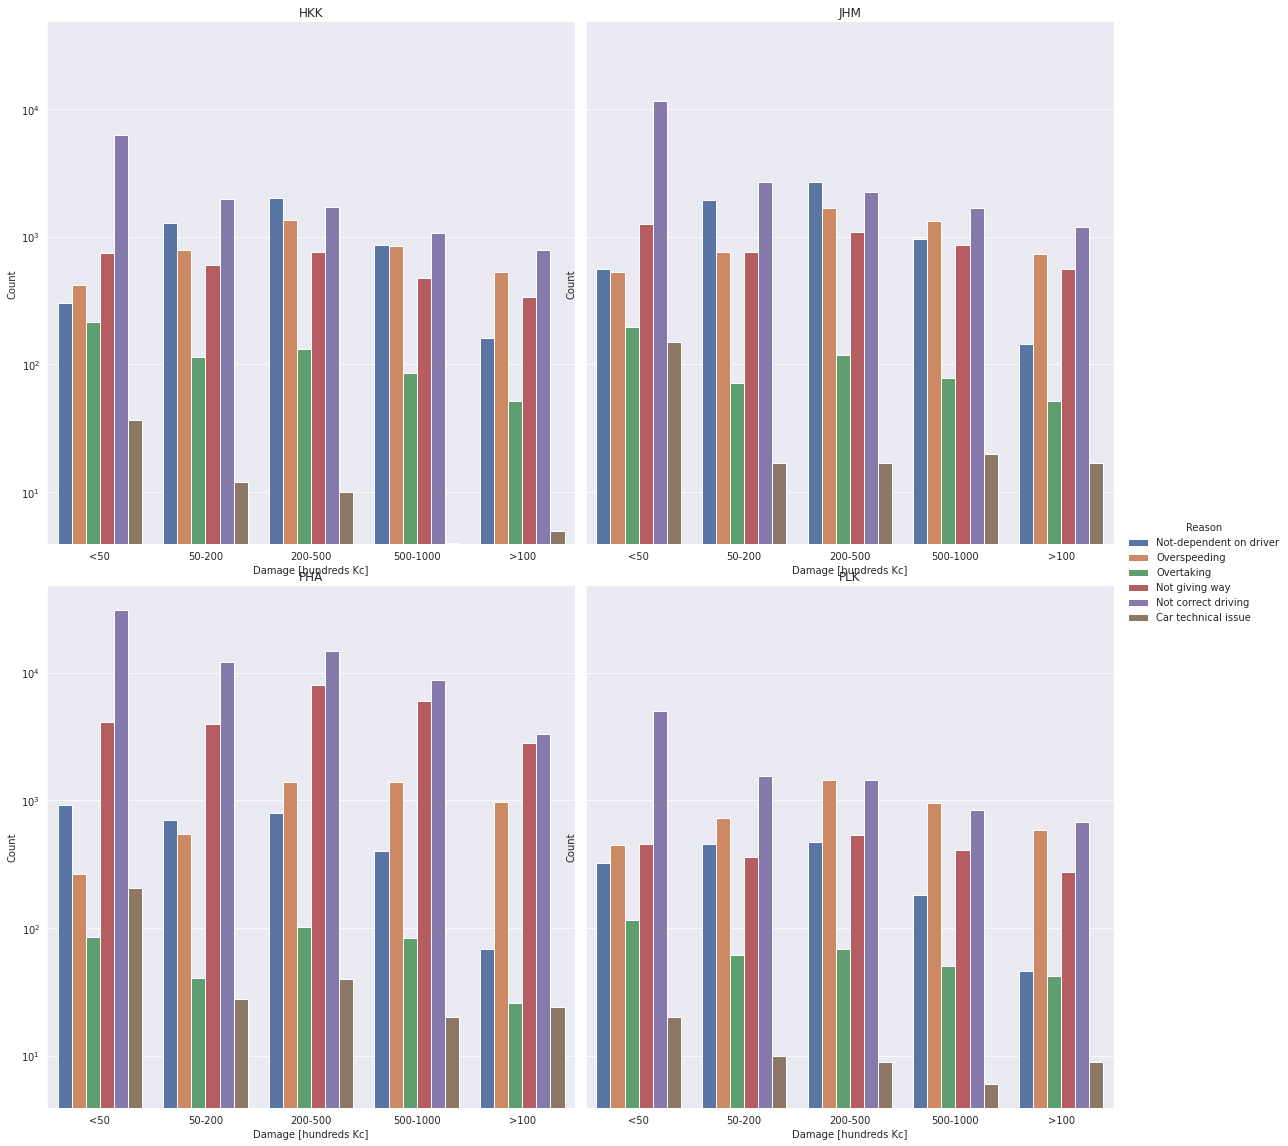

In [179]:
def plot_damage(df: pd.DataFrame, fig_location: str = None,
                show_figure: bool = False):
    res = df[df['region'].isin(['JHM','HKK','PLK','PHA'])][["region", "p53", "p12"]]

    labels = ["Not-dependent on driver", "Overspeeding", "Overtaking", "Not giving way", "Not correct driving", "Car technical issue"]
    idx = pd.IntervalIndex.from_tuples([(99,100), (200, 209), (300, 311), (400, 414), (500, 516), (600, 616)], closed="both")
    res["reason"] = pd.CategoricalIndex(pd.cut(res["p12"], bins=idx)).rename_categories({interval: name for interval, name in zip(idx.values, labels)})

    labels = ["<50", "50-200", "200-500", "500-1000", ">100"]
    idx = pd.IntervalIndex.from_tuples([(0,50), (50, 200), (200, 500), (500, 1000), (1000,100_000_000)], closed="left")
    res["range"] = pd.CategoricalIndex(pd.cut(res["p53"], bins=idx)).rename_categories({interval: name for interval, name in zip(idx.values, labels)})

    res = res.groupby(["region", "range", "reason"]).agg({"p53":"count"}).reset_index()
    sns.set_style("darkgrid")

    fg = sns.FacetGrid(data=res,
                      col='region',
                      col_wrap = 2,
                      sharex=False,
                      sharey=True,
                      height=8,
                      aspect=1, 
                      legend_out=True)
    # set plots on grid
    fg.map(sns.barplot, "range", "p53", "reason", palette="deep", )
    fg.set(yscale="log")
    fg.add_legend(title="Reason")
    fg.tight_layout(pad=5, h_pad=4.5, rect=[1, 1, 1, 1])
    # plt.figure(figsize=(10,18))
    for ax in fg.axes.flatten():
        ax.set_title(ax.get_title().split("= ")[-1])
        ax.set_xlabel("Damage [hundreds Kc]")
        ax.set_ylabel("Count")
    
    if fig_location is not None:
        plt.savefig(fig_location)
    if show_figure:
        plt.show()
    
plot_damage(df, "02_priciny.png", True)